In [36]:
import numpy as np
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column
from scipy.stats import binned_statistic_2d

import datetime
import os 

import matplotlib.pyplot as plt 
from matplotlib import rcParams      
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 24
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 20



In [37]:

def calcWeightedMean(y,yerr):
    ''' Calculate the weighted mean '''
    N = len(y)
    if N == 1 : 
        return float(y)    
    elif N == 0 : 
        return np.nan
    else: 
        # weights = 1 / (yerr ** 2.0)  
        # wMean = np.sum(weights * flux) / np.sum(weights)
        return float(np.add.reduce(y / (yerr * yerr)) / np.add.reduce((1/yerr)*(1/yerr)))
    
def SigmaClipLC(y, sigmathresh):
    '''
    Return only the indices of those points that are 
    within the n-sigma limit, and those that are outside 
    '''
    q25, q50, q75 = np.percentile(y, (25, 50, 75))
    iqrSig = 0.7413*(q75 - q25)
    nsigma = np.abs(y - q50)/iqrSig
    idxIn  = np.where(nsigma <= sigmathresh)
    idxOut = np.where(nsigma >= sigmathresh)
    return idxIn, idxOut



    

In [38]:
# Read in stars ...
address = '../data_products/CRTS_SDSS_combined_stars_catalog.dat'
stars = Table.read(address, format='ascii') 

# display their colnames
print(np.ravel(stars.colnames))

# How many ? 
# Note:  this involves only stars that have more than 10 separate observing days 
# (i.e. are later used for structure function and day-averaging... )
print('We have %d CRTS stars ! '%len(stars))

['raw_mjd_span' 'raw_mean_mag' 'raw_mean_err' 'CRTS_name' 'raw_lc_length'
 'proc_mean_N_day' 'proc_mean_err' 'proc_lc_length' 'proc_mean_mag'
 'proc_mjd_span' 'ra_1' 'dec_1' 'calib_fla' 'ra_2' 'dec_2' 'raRMS' 'decRMS'
 'nEpochs' 'AR_val' 'u_Nobs' 'u_mMed' 'u_mMean' 'u_mErr' 'u_rms_scatt'
 'u_chi2' 'g_Nobs' 'g_mMed' 'g_mMean' 'g_mErr' 'g_rms_scatt' 'g_chi2'
 'r_Nobs' 'r_mMed' 'r_mMean' 'r_mErr' 'r_rms_scatt' 'r_chi2' 'i_Nobs'
 'i_mMed' 'i_mMean' 'i_mErr' 'i_rms_scatt' 'i_chi2' 'z_Nobs' 'z_mMed'
 'z_mMean' 'z_mErr' 'z_rms_scatt' 'z_chi2']
We have 48250 CRTS stars ! 


### Run the calculation 

In [126]:
from CRTS_paper_modules import update_progress

store = {'NtotalIn':np.zeros(len(stars)),'Noutliers':np.zeros(len(stars)),
         'wMeanMag':np.zeros(len(stars)), 'medianMag':np.zeros(len(stars)), 
         'sigmaG_z_Mag':np.zeros(len(stars)), 'chi2dof':np.zeros(len(stars)),
         'medianMagerr':np.zeros(len(stars)), 'sigmaG_y_Mag':np.zeros(len(stars)), 
         'medianMagerr_CORR':np.zeros(len(stars)),'wMeanMag_CORR':np.zeros(len(stars)),   
         'chi2dof_CORR':np.zeros(len(stars)),'sigmaG_z_Mag_CORR':np.zeros(len(stars)),
         'NpointsCORR':np.zeros(len(stars))}

#i=0
k = 0
total = float(len(stars))
lc_dir = '../raw_LC_CRTS/stars/' 
for i in range(len(stars)):
    percent = 100*(k / total)
    if (k % 10) == 0 : # every tenth loop.. 
        update_progress(int(percent))
    k += 1
    name = str(stars['CRTS_name'][i]) # choose lightcurve from LC catalog 
    address = lc_dir + name+'.dat'
    
    data=np.loadtxt(address) 
    
    t = data[:,0]
    y = data[:,1]
    yerr = data[:,2]
    
    
    #data = Table.read(address, format='ascii') # read in the lightcurve 
    #data.rename_column('col1', 'MJD')
    #data.rename_column('col2', 'Mag')
    #data.rename_column('col3', 'Magerr')
    #data.sort('MJD')
    
    
    #t = data['MJD']
    #y = data['Mag']
    #yerr = data['Magerr']

    # sigma - clip the lightcurve 
    #print('\nUsing sigma threshold of %.2f sigma '%sigmathresh)
    idxIn, idxOut= SigmaClipLC(y, sigmathresh=2.5)
    #if idxOut[0].size == 0 : 
    #    print('There are no outliers')
    #else : 
    #    print('There are %d outliers '%idxOut[0].size)
    

    store['Noutliers'][i] = idxOut[0].size
    store['medianMag'][i] = np.median(y[idxIn])
    store['medianMagerr'][i] = np.median(yerr[idxIn])
    store['sigmaG_y_Mag'][i] = 0.7413*(np.percentile(y[idxIn],75)- np.percentile(y[idxIn],25))
   
    N_pts = len(t[idxIn])
    store['NtotalIn'][i] = N_pts

    err_weights = 1 / (yerr[idxIn]**2.0)
    wMean = calcWeightedMean(y[idxIn], err_weights)
    store['wMeanMag'][i] = wMean

    z = (y[idxIn]- wMean)/ yerr[idxIn]
    store['chi2dof'][i] = (1 / (N_pts -1.0)) * np.sum(z**2)
    store['sigmaG_z_Mag'][i] = 0.7413*(np.percentile(z,75) - np.percentile(z,25))
    
    
    # correct errors and recalculate few parameters ....
    minimum_err = 0.02
    added_err = 0.01
    
    # wherever yerr is small add 0.01 in quadrature...
    store['NpointsCORR'][i] = np.sum(yerr < minimum_err)
    if np.sum(yerr < minimum_err)  > 0 :   # if at least one corrected point... 
        yerr[idxIn][yerr[idxIn] < minimum_err] = np.sqrt(yerr[idxIn][yerr[idxIn]<minimum_err] ** 2.0 + added_err**2.0)
        store['medianMagerr_CORR'][i] = np.median(yerr[idxIn])

        err_weights = 1 / (yerr[idxIn]**2.0)
        wMean = calcWeightedMean(y[idxIn], err_weights)
        store['wMeanMag_CORR'][i] = wMean
        z = (y[idxIn]- wMean)/ yerr[idxIn]
        store['chi2dof_CORR'][i] = (1 / (N_pts -1.0)) * np.sum(z**2)
        store['sigmaG_z_Mag_CORR'][i] = 0.7413*(np.percentile(z,75) - np.percentile(z,25))
        
    else : 
        store['medianMagerr_CORR'][i] = store['medianMagerr'][i]
        store['wMeanMag_CORR'][i] = store['wMeanMag'][i]
        store['chi2dof_CORR'][i] = store['chi2dof'][i]
        store['sigmaG_z_Mag_CORR'][i] = store['sigmaG_z_Mag'][i] 


[######### ] 99.00%

In [ ]:
# SAVE the results of calculation ... 

outDir = '../data_products/Fig_A1_data/2017-03-16/'
np.save(outDir+'CRTS_stars_variability_stats_store', store )

## Read the calculation results ... 

In [42]:
np.unique(store['medianMagerr'])

array([ 0.05 ,  0.055,  0.06 ,  0.065,  0.07 ,  0.075,  0.08 ,  0.085,
        0.09 ,  0.095,  0.1  ,  0.105,  0.11 ,  0.115,  0.12 ,  0.125,
        0.13 ,  0.135,  0.14 ,  0.145,  0.15 ,  0.155,  0.16 ,  0.165,
        0.17 ,  0.175,  0.18 ,  0.185,  0.19 ,  0.195,  0.2  ,  0.205,
        0.21 ,  0.21 ,  0.215,  0.215,  0.22 ,  0.225,  0.225,  0.23 ,
        0.23 ,  0.235,  0.24 ,  0.245,  0.25 ,  0.255,  0.26 ,  0.265,
        0.27 ,  0.275,  0.28 ,  0.285,  0.29 ,  0.29 ,  0.295,  0.295,
        0.3  ,  0.305,  0.31 ,  0.315,  0.32 ,  0.325,  0.325,  0.33 ,
        0.33 ,  0.335,  0.335,  0.34 ,  0.34 ,  0.345,  0.35 ,  0.355,
        0.36 ,  0.365,  0.37 ,  0.375,  0.38 ,  0.385,  0.39 ,  0.395,
        0.4  ,  0.405,  0.41 ,  0.41 ,  0.415,  0.415,  0.42 ,  0.42 ,
        0.425,  0.425,  0.43 ,  0.43 ,  0.435,  0.44 ,  0.44 ,  0.445,
        0.445,  0.45 ,  0.45 ,  0.455,  0.455,  0.46 ,  0.46 ,  0.465,
        0.47 ,  0.475,  0.48 ,  0.485,  0.49 ,  0.495,  0.5  ,  0.51 ])

In [131]:
# good to know : not even  a single point had a smaller error than 0.01 ! 
np.sum(store['NpointsCORR'])

0.0

In [326]:
# What is the total number of points across all lightcurves after outlier removal (2.5 sigma clipping ? )

N_in = np.sum(store['NtotalIn'])
print('Points that were accepted %d' % N_in)

# What is the total number of points removed?  

N_removed = np.sum(store['Noutliers'])
print('Points that were rejected %d '%N_removed)

# What is the percentage of points removed of the total population ? 

print('Percentage of points removed from total initial sample %.2f %% '% (100*(N_removed / (N_removed + N_in))))

Points that were accepted 10637723
Points that were rejected 530652 
Percentage of points removed from total initial sample 4.75 % 


530652.0

NameError: name 'N_removed' is not defined

(array([     0.,      0.,      0.,      0.,      0.,  48250.,      0.,
             0.,      0.,      0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <a list of 10 Patch objects>)

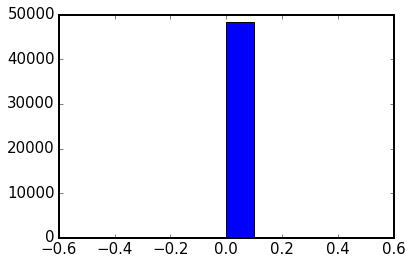

In [129]:
plt.hist(store['NpointsCORR'] / (store['NtotalIn'] + store['Noutliers']))

In [183]:
# Try to stack all errors for our stars, 
# to plot distribution of raw errors...

# I never run that for more than 60% of sample, because it simply slows down way 
# too much... (np.append is not very efficient : would be easier to do 
# assign an array of errors from a given lightcurve to predefined array, but 
# need to find out how big this array should be... )
# Plot distribution of all raw errors in stars...

yerr_stack = np.zeros(0)

k = 0
total = float(len(stars))
lc_dir = '../raw_LC_CRTS/stars/' 
for i in range(len(stars)):
    percent = 100*(k / total)
    if (k % 10) == 0 : # every tenth loop.. 
        update_progress(int(percent))
    k += 1
    name = str(stars['CRTS_name'][i]) # choose lightcurve from LC catalog 
    address = lc_dir + name+'.dat'
    
    data=np.loadtxt(address) 
    
    #t = data[:,0]
    #y = data[:,1]
    yerr = data[:,2]
    yerr_stack  = np.append(yerr_stack, yerr)
 
    
    

[######    ] 60.00%

KeyboardInterrupt: 

In [184]:
min(yerr_stack)

0.050000000000000003

In [188]:
len(yerr_stack)

6076003

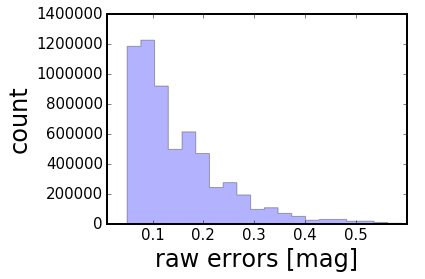

In [187]:
fig,ax = plt.subplots(1,1)
xmax = 0.6
m = yerr_stack < xmax
ax.hist(yerr_stack[m], histtype='stepfilled', alpha=0.3, bins=20)
ax.set_xlim(0.01,xmax)
ax.set_xlabel('raw errors [mag]')
ax.set_ylabel('count')
plt.tight_layout()
plt.savefig('../data_products/Fig_A1_data/2017-03-16/CRTS_stars_raw_error_hist.png')

In [141]:
len(yerr_stack)

4431259

In [25]:
for key in store.keys():
    print('%s :%f '% (key, store[key][2]))

NtotalIn :131.000000 
sigmaG_z_Mag :0.423600 
medianMag :17.840000 
Noutliers :7.000000 
chi2dof :0.111171 
wMeanMag :17.841534 


Outside left plot : 581 objects 
Outside right plot : 581 objects 


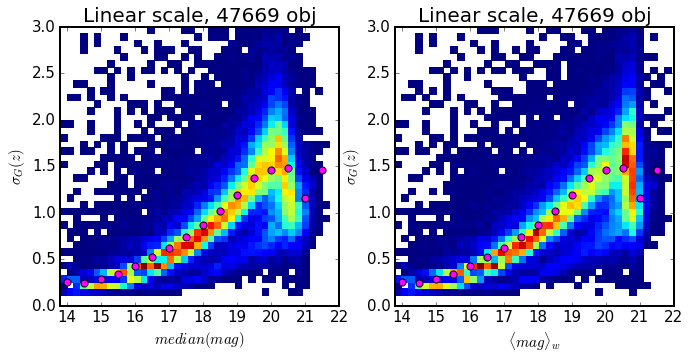

In [73]:
%matplotlib inline 
# Make the desired plots...



sigmaG_max = 3
xmin, xmax = 13.8, 22
m = (store['sigmaG_z_Mag'] < sigmaG_max ) * (xmin < store['medianMag']) * ( store['medianMag']< xmax)

stats = binned_statistic_2d(x=store['medianMag'][m], y=store['sigmaG_z_Mag'][m], 
                            values=store['medianMag'][m], statistic='count', bins=40)

z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
# replace all nan's by 0 ...
z_sigma[np.isnan(z_sigma)] =0 
z_reduce  =  z_sigma 
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
z_rot_flip = np.flipud(z_rot)
z_masked_var = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)  # mask out zeros... 

# Plot 2D histogram using pcolor
fig,ax = plt.subplots(1,2, figsize=(11,5))
image = ax[0].pcolormesh(x_edges,y_edges,z_masked_var, cmap='jet')
#ax[1].hexbin(store['wMeanMag'][m],store['sigmaG_z_Mag'][m], gridsize=50, cmap='Blues' )
ax[0].set_xlabel(r'$median(mag)$', fontsize=15)
ax[0].set_ylabel(r'$\sigma_{G}(z)$', fontsize=15)
ax[0].set_title('Linear scale, %d obj'%(len(store['wMeanMag'][m])))
ax[0].tick_params(axis='both', which='major', labelsize=15) 
ax[0].set_ylim(0,sigmaG_max)
#colorbar_ax = fig.add_axes([0.2, 0.61, 0.4, 0.01])
#colorbar = fig.colorbar(image,  cax=colorbar_ax, orientation='horizontal')

# Calculate the mean sigmaG(z)  per bins of weighted magnitudes.... 
mean_mag = np.arange(14,22.5,0.5) # set the magnitude bins ... 
median_sigmaG = np.zeros(len(mean_mag)-1) # store the values 

for j in range(len(median_sigmaG)):
    # take points that have the desired magnitudes (vertically)
    mask =  (mean_mag[j]<store['wMeanMag'][m])*(store['wMeanMag'][m]<  mean_mag[j+1])
    median_sigmaG[j] = np.median(store['sigmaG_z_Mag'][m][mask])
ax[0].scatter(mean_mag[:-1], median_sigmaG, c = 'magenta', s=50)
ax[0].set_xlim(xmin, xmax)
print('Outside left plot : %d objects '%np.sum(~m))





sigmaG_max = 3
xmin, xmax = 13.8, 22
m = (store['sigmaG_z_Mag'] < sigmaG_max ) * (xmin < store['wMeanMag']) * ( store['wMeanMag']< xmax)

stats = binned_statistic_2d(x=store['wMeanMag'][m], y=store['sigmaG_z_Mag'][m], 
                            values=store['wMeanMag'][m], statistic='count', bins=40)

z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
# replace all nan's by 0 ...
z_sigma[np.isnan(z_sigma)] =0 
z_reduce  =  z_sigma 
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
z_rot_flip = np.flipud(z_rot)
z_masked_var = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)  # mask out zeros... 

# Plot 2D histogram using pcolor

image = ax[1].pcolormesh(x_edges,y_edges,z_masked_var, cmap='jet')
#ax[1].hexbin(store['wMeanMag'][m],store['sigmaG_z_Mag'][m], gridsize=50, cmap='Blues' )
ax[1].set_xlabel(r'$\langle mag \rangle_{w}$', fontsize=15)
ax[1].set_ylabel(r'$\sigma_{G}(z)$', fontsize=15)
ax[1].set_title('Linear scale, %d obj'%(len(store['wMeanMag'][m])))
ax[1].tick_params(axis='both', which='major', labelsize=15) 
ax[1].set_ylim(0,sigmaG_max)
#colorbar_ax = fig.add_axes([0.2, 0.61, 0.4, 0.01])
#colorbar = fig.colorbar(image,  cax=colorbar_ax, orientation='horizontal')

# Calculate the mean sigmaG(z)  per bins of weighted magnitudes.... 
mean_mag = np.arange(14,22.5,0.5) # set the magnitude bins ... 
median_sigmaG = np.zeros(len(mean_mag)-1) # store the values 

for j in range(len(median_sigmaG)):
    # take points that have the desired magnitudes (vertically)
    mask =  (mean_mag[j]<store['wMeanMag'][m])*(store['wMeanMag'][m]<  mean_mag[j+1])
    median_sigmaG[j] = np.median(store['sigmaG_z_Mag'][m][mask])
ax[1].scatter(mean_mag[:-1], median_sigmaG, c = 'magenta', s=50)
ax[1].set_xlim(xmin, xmax)
print('Outside right plot : %d objects '%np.sum(~m))

plt.savefig('../data_products/Fig_A1_data/2017-03-15/CRTS_stars_sigmaG_z.png')

In [75]:
store.keys()


dict_keys(['NtotalIn', 'sigmaG_z_Mag', 'medianMag', 'Noutliers', 'chi2dof', 'wMeanMag'])

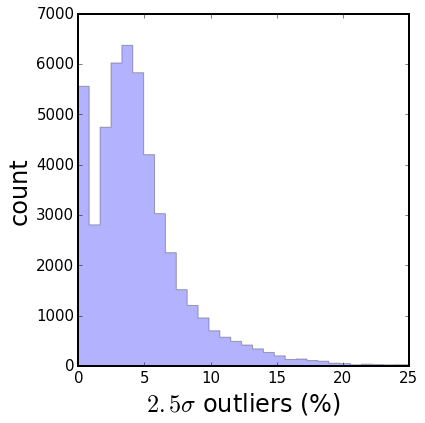

In [96]:
fig,ax = plt.subplots(figsize=(6,6))
ax.hist((store['Noutliers'] / (store['NtotalIn']+ store['Noutliers']))*100, bins=50 ,histtype='stepfilled', alpha=0.3)
ax.set_xlabel(r'$2.5 \sigma $'+' outliers (%)')
ax.set_ylabel('count')
ax.set_xlim(0,25)
plt.tight_layout()
plt.savefig('../data_products/Fig_A1_data/2017-03-15/CRTS_stars_percentage_of_outlier_points.png')

In [84]:
np.median((store['Noutliers'] / (store['NtotalIn'] + store['Noutliers']))*100)

3.9473684210526314

In [132]:
store.keys()

dict_keys(['NtotalIn', 'wMeanMag_CORR', 'medianMag', 'sigmaG_y_Mag', 'chi2dof', 'Noutliers', 'wMeanMag', 'sigmaG_z_Mag', 'medianMagerr_CORR', 'NpointsCORR', 'sigmaG_z_Mag_CORR', 'chi2dof_CORR', 'medianMagerr'])

In [134]:
np.sum(store['sigmaG_z_Mag'] - store['sigmaG_z_Mag_CORR'])

0.0

Outside left plot : 581 objects 
Outside left plot : 581 objects 


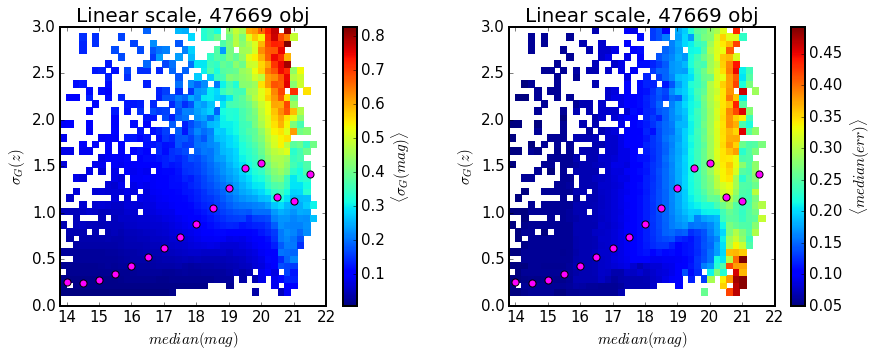

In [181]:
# plot sigmaG(z)  vs median(mag)  , coloring by   :
# 1) sigmaG(mag)
# 2) median(magerr)
# 3) sigmaG(z)_CORR  : the same as sigmaG(z), since not even a single point was < 0.01 mag in error ! 


%matplotlib inline 
# Make the desired plots...
from scipy.stats import binned_statistic_2d


sigmaG_max = 3
xmin, xmax = 13.8, 22
m = (store['sigmaG_z_Mag'] < sigmaG_max ) * (xmin < store['medianMag']) * ( store['medianMag']< xmax)

stats = binned_statistic_2d(x=store['medianMag'][m], y=store['sigmaG_z_Mag'][m], 
                            values=store['sigmaG_y_Mag'][m], statistic='mean', bins=40)

z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
# replace all nan's by 0 ...
z_sigma[np.isnan(z_sigma)] =0 
z_reduce  =  z_sigma 
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
z_rot_flip = np.flipud(z_rot)
z_masked_var = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)  # mask out zeros... 

# Plot 2D histogram using pcolor
fig,ax = plt.subplots(1,2, figsize=(14,5))
image = ax[0].pcolormesh(x_edges,y_edges,z_masked_var, cmap='jet')
#ax[1].hexbin(store['wMeanMag'][m],store['sigmaG_z_Mag'][m], gridsize=50, cmap='Blues' )
ax[0].set_xlabel(r'$median(mag)$', fontsize=15)
ax[0].set_ylabel(r'$\sigma_{G}(z)$', fontsize=15)
ax[0].set_title('Linear scale, %d obj'%(len(store['wMeanMag'][m])))
ax[0].tick_params(axis='both', which='major', labelsize=15) 
ax[0].set_ylim(0,sigmaG_max)
#colorbar_ax = fig.add_axes([0.2, 0.61, 0.4, 0.01])
#colorbar = fig.colorbar(image,  cax=colorbar_ax, orientation='horizontal')

# Calculate the mean sigmaG(z)  per bins of weighted magnitudes.... 
mean_mag = np.arange(14,22.5,0.5) # set the magnitude bins ... 
median_sigmaG = np.zeros(len(mean_mag)-1) # store the values 

for j in range(len(median_sigmaG)):
    # take points that have the desired magnitudes (vertically)
    mask =  (mean_mag[j]<store['medianMag'][m])*(store['medianMag'][m]<  mean_mag[j+1])
    median_sigmaG[j] = np.median(store['sigmaG_z_Mag'][m][mask])
ax[0].scatter(mean_mag[:-1], median_sigmaG, c = 'magenta', s=50)
ax[0].set_xlim(xmin, xmax)
print('Outside left plot : %d objects '%np.sum(~m))

#colorbar_ax = fig.add_axes([0.5, 0.1, 0.1, 0.8])
#colorbar = fig.colorbar(image, cax = colorbar_ax , orientation='vertical')

colorbar = fig.colorbar(image, ax=ax[0], orientation='vertical')
colorbar.set_label(label=r'$\langle \sigma_{G}(mag)\rangle$',size=15)

stats = binned_statistic_2d(x=store['medianMag'][m], y=store['sigmaG_z_Mag'][m], 
                            values=store['medianMagerr'][m], statistic='mean', bins=40)

z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
# replace all nan's by 0 ...
z_sigma[np.isnan(z_sigma)] =0 
z_reduce  =  z_sigma 
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
z_rot_flip = np.flipud(z_rot)
z_masked_var = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)  # mask out zeros... 

# Plot 2D histogram using pcolor
image = ax[1].pcolormesh(x_edges,y_edges,z_masked_var, cmap='jet')
#ax[1].hexbin(store['wMeanMag'][m],store['sigmaG_z_Mag'][m], gridsize=50, cmap='Blues' )
ax[1].set_xlabel(r'$median(mag)$', fontsize=15)
ax[1].set_ylabel(r'$\sigma_{G}(z)$', fontsize=15)
ax[1].set_title('Linear scale, %d obj'%(len(store['wMeanMag'][m])))
ax[1].tick_params(axis='both', which='major', labelsize=15) 
ax[1].set_ylim(0,sigmaG_max)
#colorbar_ax = fig.add_axes([0.2, 0.61, 0.4, 0.01])
#colorbar = fig.colorbar(image,  cax=colorbar_ax, orientation='horizontal')

# Calculate the mean sigmaG(z)  per bins of weighted magnitudes.... 
mean_mag = np.arange(14,22.5,0.5) # set the magnitude bins ... 
median_sigmaG = np.zeros(len(mean_mag)-1) # store the values 

for j in range(len(median_sigmaG)):
    # take points that have the desired magnitudes (vertically)
    mask =  (mean_mag[j]<store['medianMag'][m])*(store['medianMag'][m]<  mean_mag[j+1])
    median_sigmaG[j] = np.median(store['sigmaG_z_Mag'][m][mask])
ax[1].scatter(mean_mag[:-1], median_sigmaG, c = 'magenta', s=50)
ax[1].set_xlim(xmin, xmax)
print('Outside left plot : %d objects '%np.sum(~m))
colorbar = fig.colorbar(image, ax=ax[1], orientation='vertical')
colorbar.set_label(label=r'$\langle median(err)\rangle$',size=15)

fig.subplots_adjust(wspace=0.35)

plt.savefig('../data_products/Fig_A1_data/2017-03-16/CRTS_stars_sigmaG_z_median_mag.png')




Outside left plot : 246 objects 
Outside left plot : 257 objects 


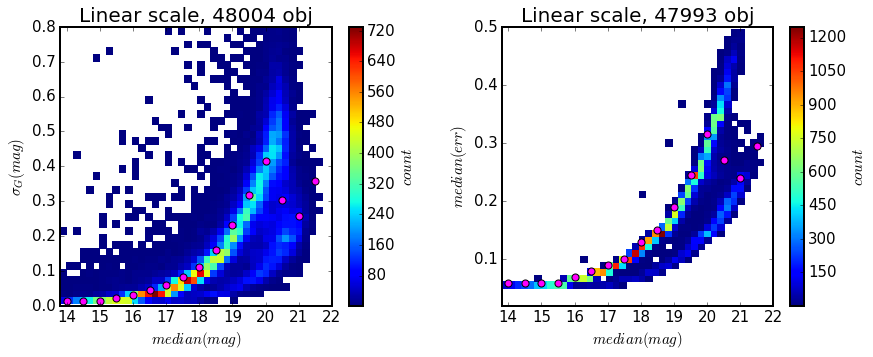

In [284]:
# Plot sigmaG(mag)  vs median(mag) ,  and 
# median(magerr)  vs median(mag)

%matplotlib inline 

sigmaG_max = 0.8
xmin, xmax = 13.8, 22
m = (store['sigmaG_y_Mag'] < sigmaG_max ) * (xmin < store['medianMag']) * ( store['medianMag']< xmax)

stats = binned_statistic_2d(x=store['medianMag'][m], y=store['sigmaG_y_Mag'][m], 
                            values=store['sigmaG_y_Mag'][m], statistic='count', bins=40)

z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
# replace all nan's by 0 ...
z_sigma[np.isnan(z_sigma)] =0 
z_reduce  =  z_sigma 
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
z_rot_flip = np.flipud(z_rot)
z_masked_var = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)  # mask out zeros... 

# Plot 2D histogram using pcolor
fig,ax = plt.subplots(1,2, figsize=(14,5))
image = ax[0].pcolormesh(x_edges,y_edges,z_masked_var, cmap='jet')
#ax[1].hexbin(store['wMeanMag'][m],store['sigmaG_z_Mag'][m], gridsize=50, cmap='Blues' )
ax[0].set_xlabel(r'$median(mag)$', fontsize=15)
ax[0].set_ylabel(r'$\sigma_{G}(mag)$', fontsize=15)
ax[0].set_title('Linear scale, %d obj'%(len(store['wMeanMag'][m])))
ax[0].tick_params(axis='both', which='major', labelsize=15) 
ax[0].set_ylim(0,sigmaG_max)
#colorbar_ax = fig.add_axes([0.2, 0.61, 0.4, 0.01])
#colorbar = fig.colorbar(image,  cax=colorbar_ax, orientation='horizontal')

# Calculate the mean sigmaG(mag)  per bins of weighted magnitudes.... 
mean_mag = np.arange(14,22.5,0.5) # set the magnitude bins ... 
median_sigmaG = np.zeros(len(mean_mag)-1) # store the values 

for j in range(len(median_sigmaG)):
    # take points that have the desired magnitudes (vertically)
    mask =  (mean_mag[j]<store['medianMag'][m])*(store['medianMag'][m]<  mean_mag[j+1])
    median_sigmaG[j] = np.median(store['sigmaG_y_Mag'][m][mask])
ax[0].scatter(mean_mag[:-1], median_sigmaG, c = 'magenta', s=50)
ax[0].set_xlim(xmin, xmax)
print('Outside left plot : %d objects '%np.sum(~m))

#colorbar_ax = fig.add_axes([0.5, 0.1, 0.1, 0.8])
#colorbar = fig.colorbar(image, cax = colorbar_ax , orientation='vertical')

colorbar = fig.colorbar(image, ax=ax[0], orientation='vertical')
colorbar.set_label(label=r'$count$',size=15)


ymin, ymax = 0.02, 0.5
mask_y =  (ymin < store['medianMagerr'])*(store['medianMagerr'] < ymax)
m = m * mask_y
stats = binned_statistic_2d(x=store['medianMag'][m], y=store['medianMagerr'][m], 
                            values=store['medianMagerr'][m], statistic='count', bins=40)

z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
# replace all nan's by 0 ...
z_sigma[np.isnan(z_sigma)] =0 
z_reduce  =  z_sigma 
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
z_rot_flip = np.flipud(z_rot)
z_masked_var = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)  # mask out zeros... 

# Plot 2D histogram using pcolor
image = ax[1].pcolormesh(x_edges,y_edges,z_masked_var, cmap='jet')
#ax[1].hexbin(store['wMeanMag'][m],store['sigmaG_z_Mag'][m], gridsize=50, cmap='Blues' )
ax[1].set_xlabel(r'$median(mag)$', fontsize=15)
ax[1].set_ylabel(r'$median(err)$', fontsize=15)
ax[1].set_title('Linear scale, %d obj'%(len(store['wMeanMag'][m])))
ax[1].tick_params(axis='both', which='major', labelsize=15) 
#ax[1].set_ylim(0,sigmaG_max)
#colorbar_ax = fig.add_axes([0.2, 0.61, 0.4, 0.01])
#colorbar = fig.colorbar(image,  cax=colorbar_ax, orientation='horizontal')

# Calculate the mean sigmaG(z)  per bins of weighted magnitudes.... 
mean_x = np.arange(14,22.5,0.5) # set the magnitude bins ... 
median_y = np.zeros(len(mean_x)-1) # store the values 

for j in range(len(median_y)):
    # take points that have the desired magnitudes (vertically)
    mask =  (mean_x[j]<store['medianMag'][m])*(store['medianMag'][m]<  mean_x[j+1])
    median_y[j] = np.median(store['medianMagerr'][m][mask])
ax[1].scatter(mean_x[:-1], median_y, c = 'magenta', s=50)
ax[1].set_xlim(xmin, xmax)
ax[1].set_ylim(ymin, ymax)
print('Outside left plot : %d objects '%np.sum(~m))
colorbar = fig.colorbar(image, ax=ax[1], orientation='vertical')
colorbar.set_label(label=r'$count$',size=15)

fig.subplots_adjust(wspace=0.3)

plt.savefig('../data_products/Fig_A1_data/2017-03-16/CRTS_stars_medMag_vs_medErr_sigGmag.png')





4081 / 48250 objects fulfill this cut 
27 / 4081 have sigmaG(mag) > 0.20


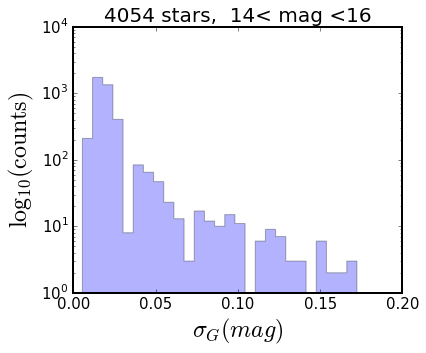

In [282]:
# Plot histograms of sigmaG(mag), and median(err),
# for      14< median(mag) < 16 

xmin, xmax = 14,16
m1 = (xmin < store['medianMag']) * ( store['medianMag']< xmax)
print('%d / %d objects fulfill this cut '%(np.sum(m1), len(m1)))

sigmaG_max = 0.2
m2 = store['sigmaG_y_Mag'] < sigmaG_max
m3 = store['sigmaG_y_Mag'][m1] < sigmaG_max
print('%d / %d have sigmaG(mag) > %.2f'%(np.sum(~m3), len(m3), sigmaG_max))

m = m1*m2 

fig,ax = plt.subplots(1,1,figsize=(6,5))

nbins = 30
alpha = 0.3 
ax.hist(store['sigmaG_y_Mag'][m], histtype='stepfilled', bins=nbins, alpha=alpha)
ax.set_xlabel(r'$\sigma_{G}(mag)$')
ax.set_ylabel(r'$\log_{10}(\mathrm{counts})$')
ax.set_yscale('log')
ax.set_title('%d stars,  %d< mag <%d'%(np.sum(m), xmin, xmax))
plt.tight_layout()
plt.savefig('../data_products/Fig_A1_data/2017-03-16/CRTS_stars_14-mag-17_sigmaGmag_hist.png')



4081 / 48250 objects fulfill this cut 


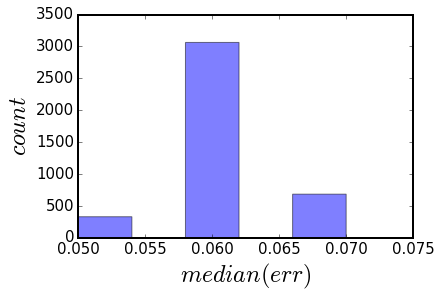

In [47]:
# plot histogram for  median(err),
# for      14< median(mag) < 16 

fig,ax = plt.subplots()
xmin, xmax = 14,16
m1 = (xmin < store['medianMag']) * ( store['medianMag']< xmax)
print('%d / %d objects fulfill this cut '%(np.sum(m1), len(m1)))
magerr_max = 200
m2 = store['medianMagerr'] < magerr_max


#m3 = store['medianMagerr'][m1] < sigmaG_max
#print('%d / %d have median(magerr) < %.2f'%(np.sum(~m3), len(m3), magerr_max))
m = m1 * m2 

ax.hist(store['medianMagerr'][m], histtype='stepfilled', bins=5, alpha=0.5)
ax.set_xlabel(r'$median(err)$')
ax.set_ylabel(r'$count$')



In [48]:
x = store['medianMagerr'][m]
values, count = np.unique(x, return_counts=True)

In [49]:
store

array([ 0.05 ,  0.055,  0.06 ,  0.065,  0.07 ])

In [50]:
count

array([ 330,    3, 3063,    1,  684])

(0.045000000000000005, 0.075000000000000011)

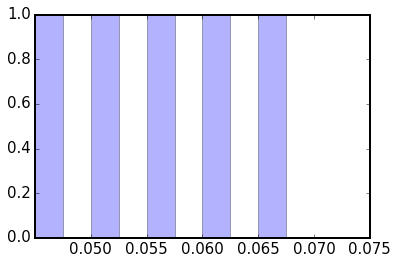

In [273]:
import matplotlib.patches as patches
x = store['medianMagerr'][m]
bin_centers, hist = np.unique(x, return_counts=True)
offset = bin_centers[1]  - bin_centers[0]

fig,ax = plt.subplots(1)

#  lower left at xy = (x, y) with specified width and height.
for p in [patches.Rectangle((bin_centers[i]-offset, 0), width=offset*0.5, height=hist[i], alpha=0.3) for i in range(len(hist))]:
    ax.add_patch(p)

ax.set_xlim(min(bin_centers) - offset, max(bin_centers)+offset)

In [269]:
hist

array([ 330,    3, 3063,    1,  684])

array([  1,   7, 185, ...,   1,   1,   1])

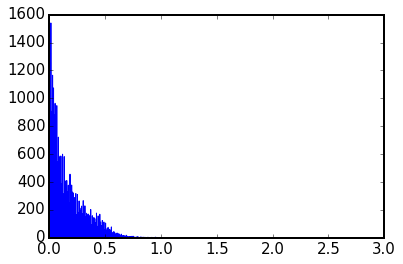

In [259]:
plt.plot(bin_centers, hist,drawstyle= 'steps-mid')
hist

## Three panels combined 

In [9]:
# read-in  the results of calculation ... 

outDir = '../data_products/Fig_A1_data/2017-03-16/'
store  = np.load(outDir+'CRTS_stars_variability_stats_store.npy' ).item()

In [14]:
# Make a Dir of today ... 
import os
import datetime

outDir = os.path.join(os.getcwd()[:-4],'data_products/'+'Fig_A1_data',
                      datetime.datetime.now().strftime('%Y-%m-%d')+ '/')
if not os.path.exists(outDir): os.system('mkdir %s' % outDir)
print('We will save this figure in  %s'%outDir)


We will save this figure in  /Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_7_data/2017-03-23/



In top plot : 47669 objects 
Outside top plot : 581 objects 

In middle plot : 48004 objects 
Outside middle plot : 246 objects 

In bottom plot : 47993 objects 
Outside bottom plot : 257 objects 


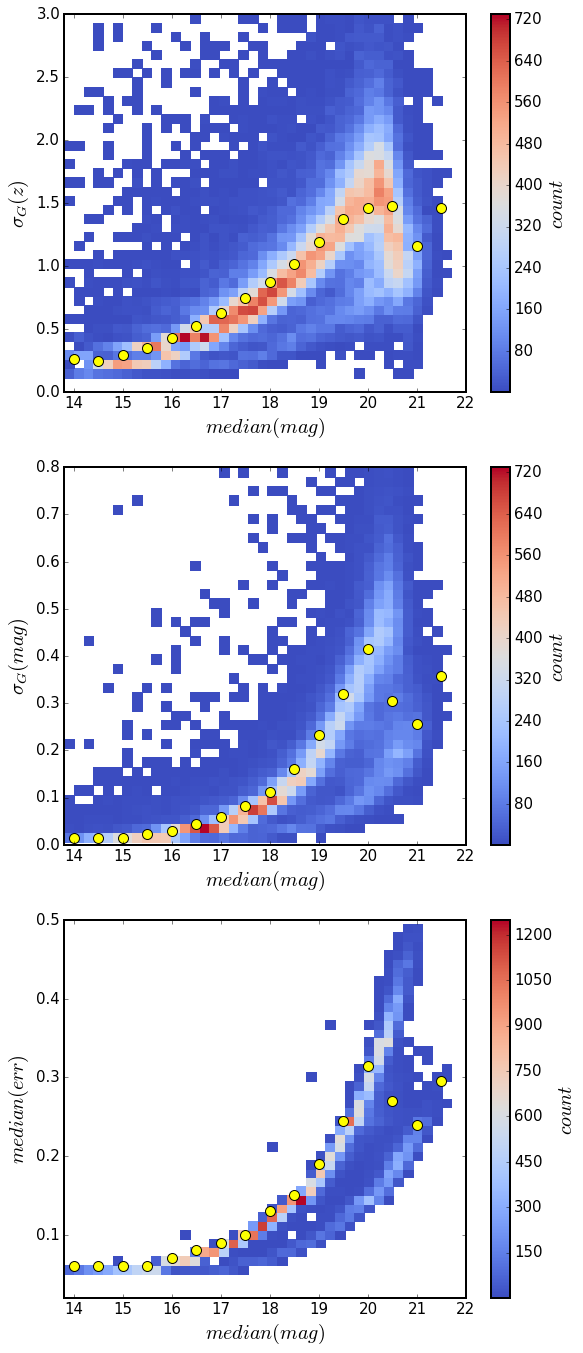

In [33]:
# Combine the three plots ..

#vertical 3-panel plot:
#top: counts in the sigmaG(z) vs. median(mag) plot  (from yesterday)
#middle: counts in the sigmaG(mag) vs. median(mag) plot  (left panel below)
#bottom: counts in the median(err) vs. median(mag) plot  (right panel below)
    

    # Plot sigmaG(mag)  vs median(mag) ,  and 
# median(magerr)  vs median(mag)

%matplotlib inline 
fig,ax = plt.subplots(3,1, figsize=(9,23))
sigmaG_max = 3
xmin, xmax = 13.8, 22
labelsize = 20
ticklabelsize = 15 

#colormap = 'jet'
colormap = 'coolwarm'
dots_color = 'yellow'
dotsize = 100

m = (store['sigmaG_z_Mag'] < sigmaG_max ) * (xmin < store['medianMag']) * ( store['medianMag']< xmax)

stats = binned_statistic_2d(x=store['medianMag'][m], y=store['sigmaG_z_Mag'][m], 
                            values=store['medianMag'][m], statistic='count', bins=40)

z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
# replace all nan's by 0 ...
z_sigma[np.isnan(z_sigma)] =0 
z_reduce  =  z_sigma 
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
z_rot_flip = np.flipud(z_rot)
z_masked_var = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)  # mask out zeros... 

# Plot 2D histogram using pcolor
image = ax[0].pcolormesh(x_edges,y_edges,z_masked_var, cmap=colormap)
#ax[1].hexbin(store['wMeanMag'][m],store['sigmaG_z_Mag'][m], gridsize=50, cmap='Blues' )
ax[0].set_xlabel(r'$median(mag)$', fontsize=labelsize)
ax[0].set_ylabel(r'$\sigma_{G}(z)$', fontsize=labelsize)
#ax[0].set_title('Linear scale, %d obj'%(len(store['wMeanMag'][m])))
ax[0].tick_params(axis='both', which='major', labelsize=ticklabelsize) 
ax[0].set_ylim(0,sigmaG_max)
#colorbar_ax = fig.add_axes([0.2, 0.61, 0.4, 0.01])
#colorbar = fig.colorbar(image,  cax=colorbar_ax, orientation='horizontal')

# Calculate the mean sigmaG(z)  per bins of weighted magnitudes.... 
mean_mag = np.arange(14,22.5,0.5) # set the magnitude bins ... 
median_sigmaG = np.zeros(len(mean_mag)-1) # store the values 

for j in range(len(median_sigmaG)):
    # take points that have the desired magnitudes (vertically)
    mask =  (mean_mag[j]<store['wMeanMag'][m])*(store['wMeanMag'][m]<  mean_mag[j+1])
    median_sigmaG[j] = np.median(store['sigmaG_z_Mag'][m][mask])
ax[0].scatter(mean_mag[:-1], median_sigmaG, c = dots_color, s=dotsize)
ax[0].set_xlim(xmin, xmax)
print('\nIn top plot : %d objects '%np.sum(m))
print('Outside top plot : %d objects '%np.sum(~m))


sigmaG_max = 0.8
xmin, xmax = 13.8, 22
m = (store['sigmaG_y_Mag'] < sigmaG_max ) * (xmin < store['medianMag']) * ( store['medianMag']< xmax)

stats = binned_statistic_2d(x=store['medianMag'][m], y=store['sigmaG_y_Mag'][m], 
                            values=store['sigmaG_y_Mag'][m], statistic='count', bins=40)

z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
# replace all nan's by 0 ...
z_sigma[np.isnan(z_sigma)] =0 
z_reduce  =  z_sigma 
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
z_rot_flip = np.flipud(z_rot)
z_masked_var = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)  # mask out zeros... 

# Plot 2D histogram using pcolor
image = ax[1].pcolormesh(x_edges,y_edges,z_masked_var, cmap=colormap)
#ax[1].hexbin(store['wMeanMag'][m],store['sigmaG_z_Mag'][m], gridsize=50, cmap='Blues' )
ax[1].set_xlabel(r'$median(mag)$', fontsize=labelsize)
ax[1].set_ylabel(r'$\sigma_{G}(mag)$', fontsize=labelsize)
#ax[1].set_title('Linear scale, %d obj'%(len(store['wMeanMag'][m])))
ax[1].tick_params(axis='both', which='major', labelsize=ticklabelsize) 
ax[1].set_ylim(0,sigmaG_max)
#colorbar_ax = fig.add_axes([0.2, 0.61, 0.4, 0.01])
#colorbar = fig.colorbar(image,  cax=colorbar_ax, orientation='horizontal')

# Calculate the mean sigmaG(mag)  per bins of weighted magnitudes.... 
mean_mag = np.arange(14,22.5,0.5) # set the magnitude bins ... 
median_sigmaG = np.zeros(len(mean_mag)-1) # store the values 

for j in range(len(median_sigmaG)):
    # take points that have the desired magnitudes (vertically)
    mask =  (mean_mag[j]<store['medianMag'][m])*(store['medianMag'][m]<  mean_mag[j+1])
    median_sigmaG[j] = np.median(store['sigmaG_y_Mag'][m][mask])
ax[1].scatter(mean_mag[:-1], median_sigmaG, c = dots_color, s=dotsize)
ax[1].set_xlim(xmin, xmax)
colorbar = fig.colorbar(image, ax=ax[1], orientation='vertical')
colorbar.set_label(label=r'$count$',size=labelsize)
print('\nIn middle plot : %d objects '%np.sum(m))
print('Outside middle plot : %d objects '%np.sum(~m))

#colorbar_ax = fig.add_axes([0.5, 0.1, 0.1, 0.8])
#colorbar = fig.colorbar(image, cax = colorbar_ax , orientation='vertical')

colorbar = fig.colorbar(image, ax=ax[0], orientation='vertical')
colorbar.set_label(label=r'$count$',size=labelsize)


ymin, ymax = 0.02, 0.5
mask_y =  (ymin < store['medianMagerr'])*(store['medianMagerr'] < ymax)
m = m * mask_y
stats = binned_statistic_2d(x=store['medianMag'][m], y=store['medianMagerr'][m], 
                            values=store['medianMagerr'][m], statistic='count', bins=40)

z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
# replace all nan's by 0 ...
z_sigma[np.isnan(z_sigma)] =0 
z_reduce  =  z_sigma 
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
z_rot_flip = np.flipud(z_rot)
z_masked_var = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)  # mask out zeros... 

# Plot 2D histogram using pcolor
image = ax[2].pcolormesh(x_edges,y_edges,z_masked_var, cmap=colormap)
#ax[1].hexbin(store['wMeanMag'][m],store['sigmaG_z_Mag'][m], gridsize=50, cmap='Blues' )
ax[2].set_xlabel(r'$median(mag)$', fontsize=labelsize)
ax[2].set_ylabel(r'$median(err)$', fontsize=labelsize)
#ax[2].set_title('Linear scale, %d obj'%(len(store['wMeanMag'][m])))
ax[2].tick_params(axis='both', which='major', labelsize=ticklabelsize) 
#ax[1].set_ylim(0,sigmaG_max)
#colorbar_ax = fig.add_axes([0.2, 0.61, 0.4, 0.01])
#colorbar = fig.colorbar(image,  cax=colorbar_ax, orientation='horizontal')

# Calculate the mean sigmaG(z)  per bins of weighted magnitudes.... 
mean_x = np.arange(14,22.5,0.5) # set the magnitude bins ... 
median_y = np.zeros(len(mean_x)-1) # store the values 

for j in range(len(median_y)):
    # take points that have the desired magnitudes (vertically)
    mask =  (mean_x[j]<store['medianMag'][m])*(store['medianMag'][m]<  mean_x[j+1])
    median_y[j] = np.median(store['medianMagerr'][m][mask])
ax[2].scatter(mean_x[:-1], median_y, c = dots_color, s=dotsize)
ax[2].set_xlim(xmin, xmax)
ax[2].set_ylim(ymin, ymax)
print('\nIn bottom plot : %d objects '%np.sum(m))
print('Outside bottom plot : %d objects '%np.sum(~m))
colorbar = fig.colorbar(image, ax=ax[2], orientation='vertical')
colorbar.set_label(label=r'$count$',size=labelsize)

#fig.subplots_adjust(wspace=0.3)
#plt.tight_layout()
plt.savefig(outDir+'CRTS_stars_three_panels.png', bbox_inches='tight')


In [311]:
store

{'Noutliers': array([  5.,  17.,   7., ...,   1.,   0.,  24.]),
 'NpointsCORR': array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 'NtotalIn': array([ 131.,   67.,  131., ...,   17.,   53.,   74.]),
 'chi2dof': array([  1.36574774e-01,   1.88873813e-02,   1.11170754e-01, ...,
          4.73184276e+00,   3.00138084e+02,   8.58100466e-01]),
 'chi2dof_CORR': array([  1.36574774e-01,   1.88873813e-02,   1.11170754e-01, ...,
          4.73184276e+00,   3.00138084e+02,   8.58100466e-01]),
 'medianMag': array([ 17.88,  15.26,  17.84, ...,  20.55,  16.62,  17.12]),
 'medianMagerr': array([ 0.07,  0.05,  0.07, ...,  0.41,  0.08,  0.09]),
 'medianMagerr_CORR': array([ 0.07,  0.05,  0.07, ...,  0.41,  0.08,  0.09]),
 'sigmaG_y_Mag': array([ 0.029652  ,  0.007413  ,  0.029652  , ...,  0.541149  ,
         1.060059  ,  0.07227675]),
 'sigmaG_z_Mag': array([  0.4236    ,   0.14826   ,   0.4236    , ...,   1.72116067,
         15.58650234,   0.74367329]),
 'sigmaG_z_Mag_CORR': array([  0.4236    ,   0.1482